In [326]:
using Pkg
Pkg.activate(".")
using OptimalTransport
using LinearAlgebra
using SparseArrays
using Distances
using NNlib
using Plots
using Random

include("../../src/util.jl")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/QROT/notebooks/ex_algs`


norm_kernel (generic function with 1 method)

In [327]:
function P1(X)
    n = size(X, 1)
    X + ((1/n) * I + (sum(X)/n^2)*I - (1/n)*X) * one.(X) - (1/n)*one.(X)*X
end

function P2(X)
    relu.(X)
end

function proj_l2_alternating(A; max_iter = 250, print_iter = 25, save_trace = false)
    trace = []
    X = copy(A)
    for i = 1:max_iter
        X .= P1(X)
        if minimum(X) >= 0
            break
        end
        X .= P2(X)
        if i % print_iter == 0
            err = norm(sum(X; dims = 1) .- 1, 2)
            if save_trace push!(trace, err) end
            @info "Iteration $(i), marginal error $err"
        end
    end
    return symm(X), trace
end

function proj_l2_newton(A; rtol = 1e-6, atol = 1e-6, maxiter = 100, kwargs...)
    C = (ones(size(A, 1)) * ones(size(A, 2))') - A
    solver = OptimalTransport.build_solver(ones(size(A, 1)), C, 1, OptimalTransport.SymmetricQuadraticOTNewton(0.1, 0.5, 1.0e-9, 250); maxiter = maxiter, atol = atol, rtol = rtol, kwargs...)
    OptimalTransport.solve!(solver)
    A = symm(OptimalTransport.plan(solver))
    return A
end

proj_l2_newton (generic function with 1 method)

In [415]:
# N = 250
N = 25
Random.seed!(0)
A = symm(randn(N, N));

In [416]:
@time X, trace = proj_l2_alternating(A; max_iter = 2_500, save_trace = true);

  0.031468 seconds (31.20 k allocations: 111.722 MiB)


[ Info: Iteration 25, marginal error 0.29633797259614025
[ Info: Iteration 50, marginal error 0.03525521541375327
[ Info: Iteration 75, marginal error 0.005389174434064351
[ Info: Iteration 100, marginal error 0.0008537583384150139
[ Info: Iteration 125, marginal error 0.00013655973934564432
[ Info: Iteration 150, marginal error 2.1910004662037204e-5
[ Info: Iteration 175, marginal error 3.518852774055583e-6
[ Info: Iteration 200, marginal error 5.653811283938899e-7
[ Info: Iteration 225, marginal error 9.085796135016466e-8
[ Info: Iteration 250, marginal error 1.46025154563548e-8
[ Info: Iteration 275, marginal error 2.3469958917124144e-9
[ Info: Iteration 300, marginal error 3.772275030538663e-10
[ Info: Iteration 325, marginal error 6.063128457436223e-11
[ Info: Iteration 350, marginal error 9.745338624319542e-12
[ Info: Iteration 375, marginal error 1.5662275667199991e-12
[ Info: Iteration 400, marginal error 2.519136899141911e-13
[ Info: Iteration 425, marginal error 4.04093729461

In [417]:
@time X_ = proj_l2_newton(A; maxiter = 250, rtol = 1e-6, atol = 1e-6);

  0.000247 seconds (449 allocations: 471.219 KiB)


In [418]:
get_err(x) = norm(sum(x; dims = 1) .- 1, 2)
trace_newton = [get_err(proj_l2_newton(A; maxiter = i, rtol = 1e-12, atol = 1e-12)) for i = 1:25:250]

┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-9, 250) (1/1): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/quadratic_newton_symm.jl:230
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-9, 250) (26/26): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/quadratic_newton_symm.jl:230
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-9, 250) (51/51): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/quadratic_newton_symm.jl:230
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-9, 250) (76/76): not converged
└ @ OptimalTransport ~/.julia/packages/OptimalTransport/p1fRd/src/quadratic_newton_symm.jl:230
┌ Warning: OptimalTransport.SymmetricQuadraticOTNewton{Float64, Float64, Float64}(0.1, 0.5, 1.0e-9, 250) (101/

10-element Vector{Float64}:
 4.076199785297086
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10
 1.657836329053453e-10

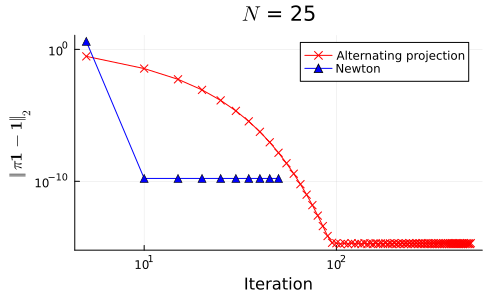

In [419]:
using LaTeXStrings
plt=plot([5*i for i = 1:length(trace)], trace; yscale = :log10, xscale = :log10, title = latexstring("\$N\$ = $(N)"), label = "Alternating projection", xlabel = "Iteration", ylabel = L"\Vert \pi \mathbf{1} - \mathbf{1} \Vert_2", marker = :x, color = :red, size = (500, 300), legend = :topright, margin = 2.5*Plots.mm)
plot!([5*i for i = 1:length(trace_newton)], trace_newton; label = "Newton", marker = :^, color = :blue)
savefig(plt, "marginal_violation_vs_iter_N_$N.pdf")
plt

In [420]:
using StatsBase
cor(vec(X), vec(X_))

0.9971107489048068

In [421]:
norm(sum(X_; dims = 1) .- 1, 2)

1.8946697100350819e-10

In [422]:
norm(sum(X; dims = 1) .- 1, 2)

2.152802317486082e-15

In [423]:
norm(X - A, 2)

17.876814333149387

In [424]:
norm(X_ - A, 2)

17.839158465486243

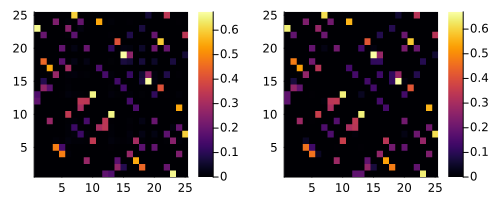

In [431]:
plot(heatmap(X), heatmap(X_), size = (500, 200))